In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

In [2]:
plt.rcParams['font.size'] = 10  # Match 12pt document font size
plt.rcParams['font.weight'] = 400

plt.rcParams['savefig.bbox'] = 'tight' # borderles pdf
plt.rcParams['svg.fonttype'] = 'none'  # selectable text
plt.rcParams['ps.fonttype'] = 42       # selectable text

plt.rcParams['legend.fontsize'] = 10
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.framealpha'] = 1
plt.rcParams['legend.edgecolor'] = 'black'

Defining constants in useful units:
- Energy: eV
- mass: atomic mass units (is converted to eV (fs/Å)²)
- Distance in Å
- time in fs

In [3]:
k_B = 8.617333262e-5  # Boltzmann constant in eV/K
mass = 157.25         # mass of Gd in u
u_to_eV = 9.31494e-5  # Conversion factor: 1 amu⋅(Å/fs)² = 9.31494e-5 eV

σ = 3.304   # in Angstrom
ϵ = 0.1136  # in eV

Setup the 3D crystal with dimensions of $x \times y \times z$ unit cells. The Gd atoms in a unit cell are positioned at
$$
r_1 = (1/4, 5/6, 1/4) \\
r_2 = (1/4, 1/6, 3/4) \\
r_3 = (3/4, 1/3, 1/4) \\
r_4 = (3/4, 2/3, 3/4)
$$
The dimensions of a single unit cell are given by $\left(a, \sqrt{3}a, \sqrt{\frac{3}{8}}a\right)$. The complete lattice is composed of 9x5x5 such unit cells (into a so-called supercell). The nearest neighbors are precomputed. Using the assumptions, that the atoms don't move a lot during the simulation, it is save to assume that this will not change

In [4]:
a = σ  # lattice parameter in Angstrom
ax, ay, az = a, np.sqrt(3) * a, np.sqrt(8/3) * a

# Basis atom positions (fractional coordinates)
basis_atoms = np.array([
    [1/4, 5/6, 1/4],
    [1/4, 1/6, 3/4],
    [3/4, 1/3, 1/4],
    [3/4, 2/3, 3/4]
])

In [5]:
def setup_Gd_crystal(Nx=9, Ny=5, Nz=5):
  lattice_points = []
  for i in range(Nx):
    for j in range(Ny):
      for k in range(Nz):
        translation = np.array([i * ax, j * ay, k * az])

        for atom in basis_atoms:
          lattice_points.append(translation + atom * [ax, ay, az])
          
  return np.array(lattice_points)

In [6]:
def find_nearest_neighbors(lattice, Nx=9, Ny=5, Nz=5, cutoff=10):
  # Apply periodic boundary conditions by considering shifts of neighboring cells
  translations = np.array([
    [dx, dy, dz] for dx in [-1, 0, 1] for dy in [-1, 0, 1] for dz in [-1, 0, 1]
  ])

  supercell_vectors = np.array([[Nx * ax, 0, 0], [0, Ny * ay, 0], [0, 0, Nz * az]])

  # Expand lattice with periodic images
  expanded_lattice = np.vstack([
    lattice + np.dot(shift, supercell_vectors)
    for shift in translations
  ])

  # use cKDTree as a very fast nearest-neighbor search algorithm. It uses indexing under the hood
  tree = cKDTree(expanded_lattice)
  neighbors_map = {}

  for i, atom in enumerate(lattice):
    neighbors = tree.query_ball_point(atom, cutoff)
    neighbors_map[i] = [n % len(lattice) for n in neighbors if (n%len(lattice)) != i]  # Map back to real indices

  return neighbors_map

In [7]:
lattice = setup_Gd_crystal()
nearest_neighbors = find_nearest_neighbors(lattice, cutoff=10)

Visualize the lattice. All atoms centered around a selected atom. Nearest neighbors are visualized in blue

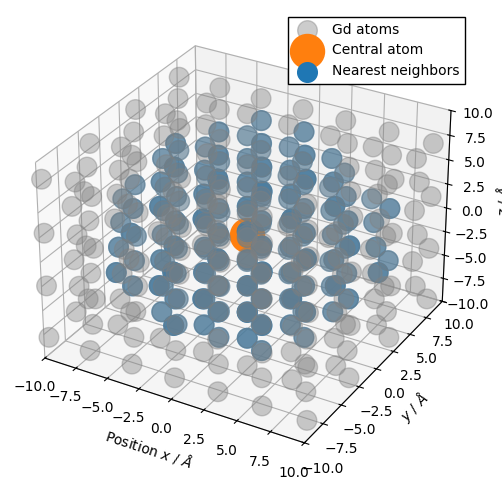

In [8]:
central_atom_idx = 532
box_size = 20

fig = plt.figure(figsize=(6, 6))
fig_ax = fig.add_subplot(111, projection='3d')

central_pos = lattice[central_atom_idx]
mid_x, mid_y, mid_z = central_pos

mask = np.all(
  (lattice > central_pos - box_size/2) & 
  (lattice < central_pos + box_size/2),
  axis=1
)

subset_indices = np.where(mask)[0]

fig_ax.scatter(lattice[subset_indices, 0] - mid_x, lattice[subset_indices, 1] - mid_y, lattice[subset_indices, 2] - mid_z, color='gray', alpha=0.4, s=200, label='Gd atoms')
fig_ax.scatter(0, 0, 0, color='C1', s=600, label='Central atom')

#show neighbors
neighbor_indices = nearest_neighbors[central_atom_idx]
neighbor_positions = lattice[neighbor_indices]
visible_neighbors = np.all(
  (neighbor_positions > central_pos - box_size/2) & 
  (neighbor_positions < central_pos + box_size/2),
  axis=1
)
visible_neighbor_positions = neighbor_positions[visible_neighbors]

fig_ax.scatter(visible_neighbor_positions[:, 0]-mid_x, 
  visible_neighbor_positions[:, 1]-mid_y, 
  visible_neighbor_positions[:, 2]-mid_z, 
  color='C0', s=200, label="Nearest neighbors")

fig_ax.set_xlabel('Position $x$ / $Å$')
fig_ax.set_ylabel('$y$ / $Å$')
fig_ax.set_zlabel('$z$ / $Å$')

max_range = box_size/2
    
fig_ax.set_xlim(-max_range, max_range)
fig_ax.set_ylim(-max_range, max_range)
fig_ax.set_zlim(-max_range, max_range)

fig_ax.grid(True)

# for top view
# fig_ax.view_init(elev=90, azim=0)

plt.legend()
plt.show()

Defining the **Lennard-Jones potential**
$$
V(\vec{x}) = \sum_{i \neq j}^{N} 4\epsilon \left[ \left(\frac{\sigma}{|\vec{x}_i - \vec{x}_j|}\right)^{12} - \left(\frac{\sigma}{|\vec{x}_i - \vec{x}_j|}\right)^6 \right]
$$
as the potential energy of the lattice

In [9]:
def lennard_jones_potential(r):
  return 4 * ϵ * ((σ/r)**12 - (σ/r)**6)

def lennard_jones_force(r):
  return 24 * ϵ * (2 * (σ/r)**12 - (σ/r)**6) / r

def V(positions, neighbors_map):
  """
    Calculate the potential energy of all particles using Lennard-Jones potential.
    
    Parameters:
    - positions: Array of shape (num_particles, 3) with positions
    - neighbors_map: Dictionary mapping atom indices to neighbor indices
    
    Returns:
    - forces: Array of shape (num_particles, 3) with forces (eV/Å)
    """
  total_energy = 0

  for atom_idx, neighbor_indices in neighbors_map.items():
    atom_pos = positions[atom_idx]
    atom_energy = 0

    for neighbor_idx in neighbor_indices:
      neighbor_pos = positions[neighbor_idx]

      r = np.linalg.norm(atom_pos - neighbor_pos)
      pair_energy = lennard_jones_potential(r)
      atom_energy += pair_energy
    
    atom_energy /= 2  # rescale for over-counting
    total_energy += atom_energy
  
  return total_energy

def F(positions, neighbors_map):
  """
    Calculate forces on all particles using Lennard-Jones potential.
    
    Parameters:
    - positions: Array of shape (num_particles, 3) with positions
    - neighbors_map: Dictionary mapping atom indices to neighbor indices
    
    Returns:
    - forces: Array of shape (num_particles, 3) with forces (eV/Å)
    """
  num_particles = len(positions)
  forces = np.zeros((num_particles, 3))

  for i, neighbors in neighbors_map.items():
    pos_i = positions[i]

    for j in neighbors:
      pos_j = positions[j]

      r_ij = pos_i - pos_j
      r = np.linalg.norm(r_ij)

      force_mag = lennard_jones_force(r)

      if r > 0:
        force_vec = force_mag * r_ij / r
        forces[i] += force_vec

        # Newton's third law
        forces[j] -= force_vec
    
  forces /= 2
  
  return forces

In [83]:
def F(positions, neighbors_map, Nx=9, Ny=5, Nz=5):
    """
    Calculate forces on all particles using Lennard-Jones potential with proper periodic boundary conditions.
    
    Parameters:
    - positions: Array of shape (num_particles, 3) with positions
    - neighbors_map: Dictionary mapping atom indices to neighbor indices
    - Nx, Ny, Nz: Supercell dimensions
    
    Returns:
    - forces: Array of shape (num_particles, 3) with forces (eV/Å)
    """
    num_particles = len(positions)
    forces = np.zeros((num_particles, 3))
    
    # Define supercell dimensions
    box_size = np.array([Nx * ax, Ny * ay, Nz * az])
    half_box = box_size / 2
    
    for i, neighbors in neighbors_map.items():
        pos_i = positions[i]
        
        for j in neighbors:
            pos_j = positions[j]
            
            # Calculate distance vector with minimum image convention
            r_ij = pos_i - pos_j
            
            # Apply minimum image convention for periodic boundary conditions
            for dim in range(3):
                if r_ij[dim] > half_box[dim]:
                    r_ij[dim] -= box_size[dim]
                elif r_ij[dim] < -half_box[dim]:
                    r_ij[dim] += box_size[dim]
            
            r = np.linalg.norm(r_ij)
            
            # Skip if atoms are at the same position (should not happen in a crystal)
            if r < 1e-10:
                continue
                
            force_mag = lennard_jones_force(r)
            force_vec = force_mag * r_ij / r
            
            forces[i] += force_vec
            # Don't apply Newton's third law here since we're iterating through all pairs
    
    return forces

def V(positions, neighbors_map, Nx=9, Ny=5, Nz=5):
    """
    Calculate the potential energy of all particles using Lennard-Jones potential with proper PBC.
    
    Parameters:
    - positions: Array of shape (num_particles, 3) with positions
    - neighbors_map: Dictionary mapping atom indices to neighbor indices
    - Nx, Ny, Nz: Supercell dimensions
    
    Returns:
    - total_energy: Total potential energy (eV)
    """
    total_energy = 0
    box_size = np.array([Nx * ax, Ny * ay, Nz * az])
    half_box = box_size / 2
    
    for atom_idx, neighbor_indices in neighbors_map.items():
        atom_pos = positions[atom_idx]
        atom_energy = 0
        
        for neighbor_idx in neighbor_indices:
            neighbor_pos = positions[neighbor_idx]
            
            # Calculate distance vector with minimum image convention
            r_vec = atom_pos - neighbor_pos
            
            # Apply minimum image convention for periodic boundary conditions
            for dim in range(3):
                if r_vec[dim] > half_box[dim]:
                    r_vec[dim] -= box_size[dim]
                elif r_vec[dim] < -half_box[dim]:
                    r_vec[dim] += box_size[dim]
            
            r = np.linalg.norm(r_vec)
            
            # Skip if atoms are at the same position (should not happen in a crystal)
            if r < 1e-10:
                continue
                
            pair_energy = lennard_jones_potential(r)
            atom_energy += pair_energy
        
        # Each pair is counted twice in the loop, so divide by 2
        atom_energy /= 2
        total_energy += atom_energy
    
    return total_energy

In [11]:
initial_energy = V(lattice, nearest_neighbors)
print(f"The initial potential energy of the lattice is {initial_energy:.2f} eV")

The initial potential energy of the lattice is -308.05 eV


Setup the initial velocity of the lattice atoms. This is given (or assumed) by the **Maxwell-Boltzmann distribution**
$$
p(v_i) = \sqrt{\frac{m_i}{2 \pi k_B T}} e^{-\frac{m_i v_i^2}{2 k_B T}}
$$
The mass of Gd atoms $m_i = 157.25 \,\mathrm{u}$ and $k_B = 8.617333262 \times 10^{-5}\,\mathrm{eV/K}$. This is just a normal distribution around $\langle v_i \rangle=0$ and $\Delta v_i = \frac{k_B T}{m_i}$

In [84]:
def maxwell_boltzmann(particle_number, T=300):
  velocities = np.zeros((particle_number, 3))

  scale = np.sqrt(k_B * T / (mass * u_to_eV))

  for i in range(3):
    velocities[:, i] = np.random.normal(0, scale, particle_number)
  
  # Remove any net momentum (center of mass motion)
  total_momentum = np.sum(velocities, axis=0)
  velocities -= total_momentum / particle_number

  return velocities
  

In [85]:
T = 300
initial_velocities = maxwell_boltzmann(len(lattice), T)

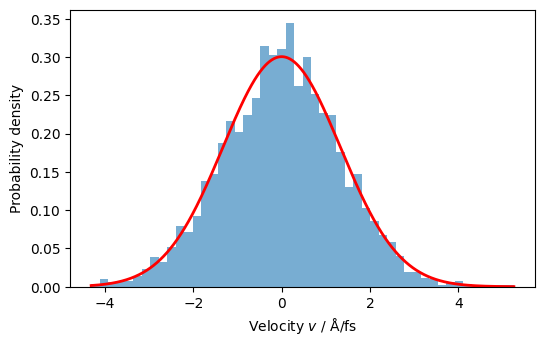

In [86]:
v_flattened = initial_velocities.flatten()

plt.figure(figsize=(6, 6*6/10))
plt.hist(v_flattened, bins=50, density=True, alpha=0.6, label='Simulation')

x = np.linspace(min(v_flattened), max(v_flattened), 1000)
scale = np.sqrt(k_B * T / (mass * u_to_eV))
plt.plot(x, np.exp(-x**2/(2*scale**2))/np.sqrt(2*np.pi*scale**2), 
             'r-', linewidth=2, label='Theoretical (Gaussian)')

plt.xlabel('Velocity $v$ / Å/fs')
plt.ylabel('Probability density')

plt.show()

In [87]:
def kinetic_energy(velocities):
  speed_sq = np.sum(velocities**2, axis=1)

  return 1/2 * (mass * u_to_eV) * np.sum(speed_sq)

def temperature(velocities):
  E_kin = kinetic_energy(velocities)
  return E_kin / (3/2 * len(velocities) * k_B)

Updating the velocity and the 

In [88]:
def run_md_simulation(lattice, velocities, neighbors_map, steps=1000, dt=0.001, Nx=9, Ny=5, Nz=5):
  """
  Run a molecular dynamics simulation with the Velocity Verlet algorithm.

  Parameters:
    - lattice: Initial positions of atoms (Å)
    - velocities: Initial velocities of atoms (Å/fs)
    - neighbors_map: Dictionary mapping atom indices to neighbor indices
    - steps: Number of simulation steps
    - dt: Time step (fs)

  Returns:
    - trajectory: Array of shape (steps, num_particles, 3) with positions over time
    - velocities_history: Array of shape (steps, num_particles, 3) with velocities over time
    - energies: Dictionary with energy components over time
  """
  num_particles = len(lattice)
  box_size = np.array([Nx * ax, Ny * ay, Nz * az])

  trajectory = np.zeros((steps, num_particles, 3))
  velocities_history = np.zeros((steps, num_particles, 3))

  energies = {
    'kinetic': np.zeros(steps),
    'potential': np.zeros(steps),
    'total': np.zeros(steps),
    'temperature': np.zeros(steps)
  }

  # Set initial positions and velocities
  positions = lattice.copy()
  trajectory[0] = positions
  velocities_history[0] = velocities

  # Set initial energy
  E_kin = kinetic_energy(velocities)
  E_pot = V(positions, neighbors_map)
  energies['kinetic'][0] = E_kin
  energies['potential'][0] = E_pot
  energies['total'][0] = E_kin + E_pot
  energies['temperature'][0] = temperature(velocities)

  # Calculate initial forces
  forces = F(positions, neighbors_map, Nx, Ny, Nz)

  for step in range(1, steps):
    # Velocity-verlet integration
    velocities += forces / (mass * u_to_eV) * dt/2
    positions += velocities * dt

    # Apply periodic boundary conditions to keep particles within the box
    positions = positions % box_size

    forces = F(positions, neighbors_map, Nx, Ny, Nz)
    velocities += forces / (mass * u_to_eV) * dt/2

    trajectory[step] = positions
    velocities_history[step] = velocities

    # Calculate energies
    E_kin = kinetic_energy(velocities)
    E_pot = V(positions, neighbors_map, Nx, Ny, Nz)

    energies['kinetic'][step] = E_kin
    energies['potential'][step] = E_pot
    energies['total'][step] = E_kin + E_pot
    energies['temperature'][step] = temperature(velocities)

    if step % 25 == 0 or step == steps - 1:
      print(f"Step {step}/{steps-1}, T = {energies['temperature'][step]:.1f} K, E_total = {energies['total'][step]:.4f} eV")
  
  return trajectory, velocities_history, energies

In [89]:
trajectories, velocities_history, energies = run_md_simulation(lattice, initial_velocities, neighbors_map=nearest_neighbors, steps=200, dt=0.001)

Step 25/199, T = 144.3 K, E_total = -394.9025 eV
Step 50/199, T = 68.5 K, E_total = -394.9017 eV
Step 75/199, T = 156.9 K, E_total = -394.9060 eV
Step 100/199, T = 145.6 K, E_total = -394.9030 eV
Step 125/199, T = 174.1 K, E_total = -394.9047 eV
Step 150/199, T = 166.3 K, E_total = -394.9046 eV
Step 175/199, T = 126.2 K, E_total = -394.9028 eV
Step 199/199, T = 154.5 K, E_total = -394.9048 eV


Text(0, 0.5, 'Potential Energy $E_{pot}$ / eV')

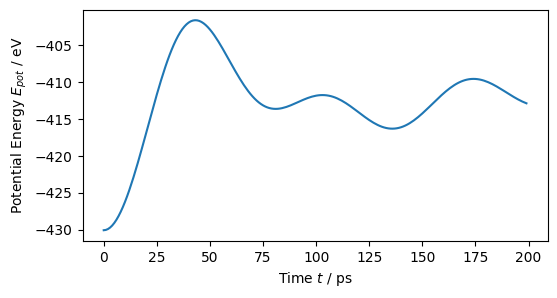

In [90]:
plt.figure(figsize=(6, 3))
plt.plot(energies["potential"])
plt.xlabel("Time $t$ / ps")
plt.ylabel(r"Potential Energy $E_{pot}$ / eV")

Text(0, 0.5, 'Kinetic Energy $E_{kin}$ / eV')

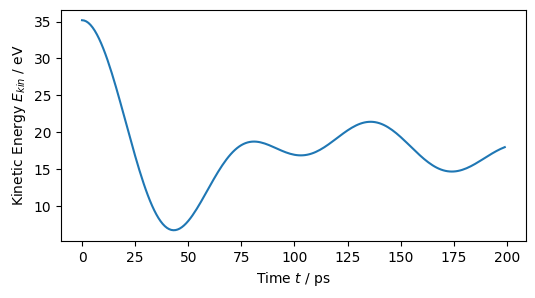

In [91]:
plt.figure(figsize=(6, 3))
plt.plot(energies["kinetic"])
plt.xlabel("Time $t$ / ps")
plt.ylabel(r"Kinetic Energy $E_{kin}$ / eV")

Text(0, 0.5, 'Temperature $T$ / K')

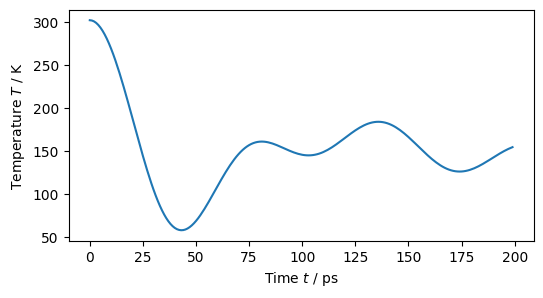

In [92]:
plt.figure(figsize=(6, 3))
plt.plot(energies["temperature"])
plt.xlabel("Time $t$ / ps")
plt.ylabel("Temperature $T$ / K")

Text(0, 0.5, 'Total Energy $E_{kin} + E_{pot}$ / eV')

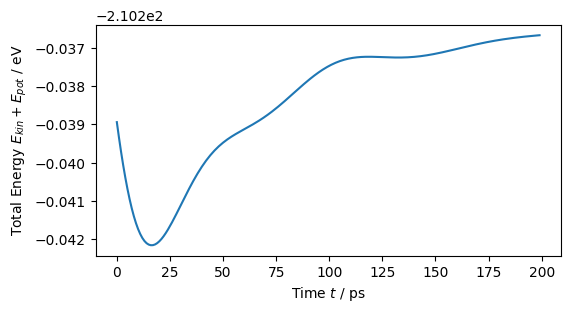

In [79]:
plt.figure(figsize=(6, 3))
plt.plot(energies["total"])
plt.xlabel("Time $t$ / ps")
plt.ylabel(r"Total Energy $E_{kin} + E_{pot}$ / eV")

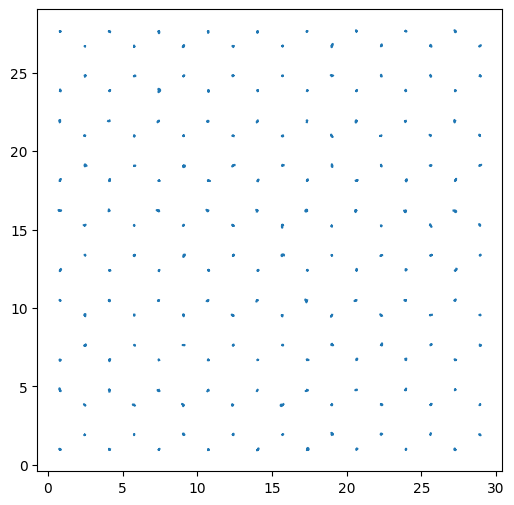

In [93]:
plt.figure(figsize=(6, 6))
for i in range(900):
  if i % 5 == 0:
    plt.plot(trajectories[:,i,0], trajectories[:,i,1], color="C0")

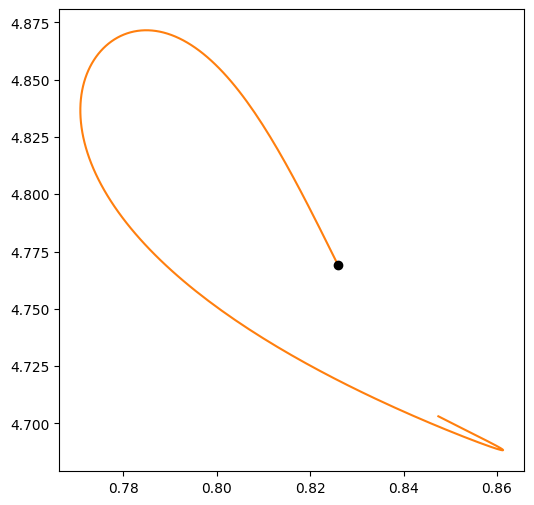

In [95]:
plt.figure(figsize=(6, 6))
plt.plot(trajectories[:,0,0], trajectories[:,0,1], color="C1")
plt.plot(trajectories[0,0,0], trajectories[0,0,1], "o", color="black")

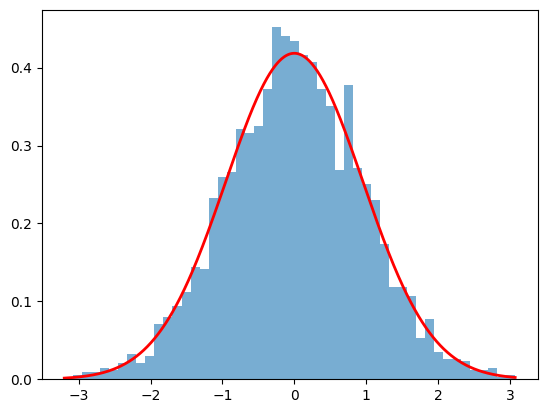

In [96]:
plt.hist(velocities_history[-1].flatten(),bins=50, density=True, alpha=0.6, label='Simulation')

x = np.linspace(min(velocities_history[-1].flatten()), max(velocities_history[-1].flatten()), 1000)
scale = np.sqrt(k_B * energies["temperature"][-1] / (mass * u_to_eV))
plt.plot(x, np.exp(-x**2/(2*scale**2))/np.sqrt(2*np.pi*scale**2), 
             'r-', linewidth=2, label='Theoretical (Gaussian)')